# testing networkx layouts

In [1]:
# connect Neo4j

from py2neo import Graph

NEO4J_USER = "neo4j" # replace with your login
NEO4J_PASS = "panamo" # replace with your password

url = 'http://localhost:7474'
graph = Graph(url + '/db/data', username = NEO4J_USER, password = NEO4J_PASS)


In [3]:
# name list and shuffle

import pandas as pd

name_list = pd.read_csv('../01-Name Hunting/_selected_names.csv')
shuffled_names = name_list.sample(frac=1).reset_index(drop=True)
first_row = shuffled_names.iloc[0]
company_name = first_row["name"]

In [9]:
node_query = '''
        MATCH (a:Entity)-[r1]-(b)-[r2]-(c)
        WHERE a.name = {name}
        RETURN a, b, c
        '''

node_results = graph.run(node_query, name = company_name)

nodes = []

for n in node_results:
    for i in n:
        node_desc = (int(i["node_id"]), {"name": i["name"]})

        if node_desc not in nodes:
            nodes.append(node_desc)

focus_node = nodes[0]
print("Focus node: "+ str(focus_node))
print("Nodes: ", len(nodes))

Focus node: (10003497, {'name': 'TOP WISDOM INTERNATIONAL LTD.'})
Nodes:  4100


In [10]:
links = []

link_query = '''
        MATCH (a:Entity)-[r1]-(b)-[r2]-(c)
        WHERE a.name = {name}
        RETURN a.node_id, b.node_id, c.node_id
        '''

link_results = graph.run(link_query, name = company_name)

def weight(start, end):
    ''' a = array of nodes to check for either start or end at focus node'''
    if focus_node[0] in [start, end]:
        return 1
    else:
        return 0.1

for l in link_results:
    a = int(l["a.node_id"])
    b = int(l["b.node_id"])
    c = int(l["c.node_id"])

    link_1 = (a, b, {'weight': weight(a,b)})
    link_2 = (b, c, {'weight': weight(b,c)})
    for link in [link_1, link_2]:
        if link not in links:
            links.append(link)

print("Links: ", len(links))

Links:  4298


In [31]:
focus_node[1]['name']

'TOP WISDOM INTERNATIONAL LTD.'

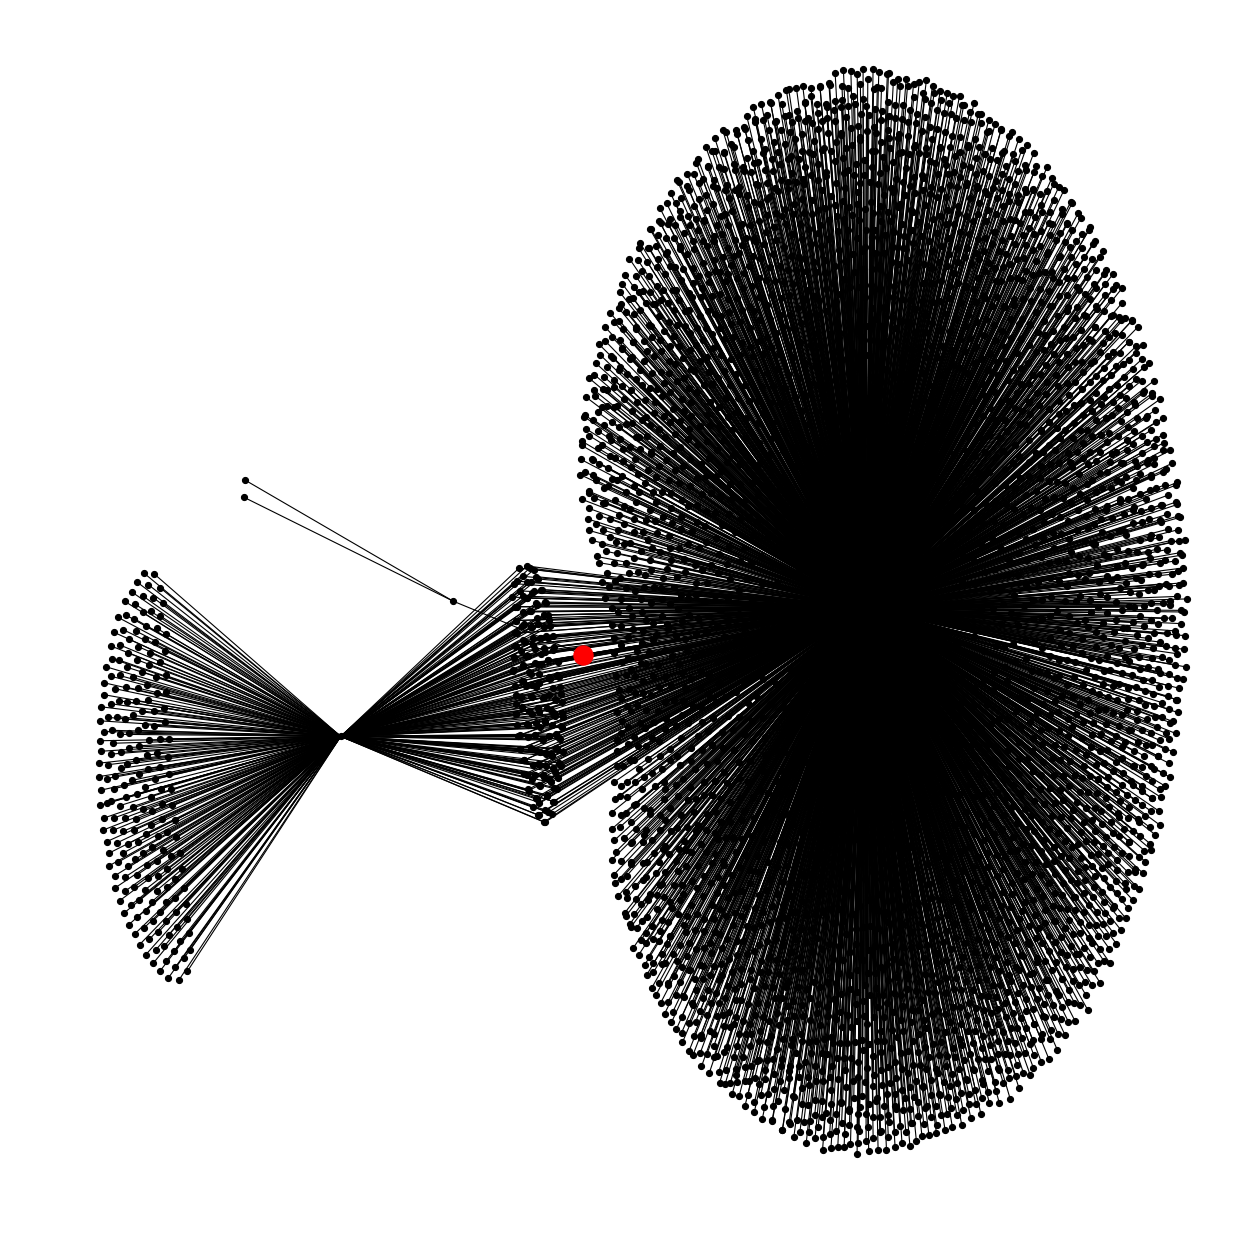

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

G = nx.Graph()

for n in nodes:
    G.add_node(n[0], name = n[1]["name"])

for edge in links:
    G.add_edge(edge[0], edge[1], weight = edge[2]['weight'])

plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
#node_and_degree= list(G.degree())
#(largest_hub,degree)=sorted(node_and_degree,key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego=nx.ego_graph(G,focus_node[0], radius=3)
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='k',node_size=30, with_labels=False)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego,pos,nodelist=[focus_node[0]],node_size=300,node_color='r', label=focus_node[1]['name'])
plt.show()